## Importing Libraries:


In [2]:
!pip install wordcloud


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.sparse import csr_matrix

import timeit, sys
from sklearn import metrics
import tqdm.notebook as tqdm

from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import hamming_loss, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix
from scipy import interp
from itertools import cycle
import matplotlib.ticker as plticker

import warnings
warnings.filterwarnings('ignore')


## Loading the DataSets

In [4]:
df_train = pd.read_csv(r"C:\Users\Gautam Sarasvat\Downloads\Malignant Comments Classifier Project\train.csv")
df_train

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
df_train.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df_test = pd.read_csv(r"C:\Users\Gautam Sarasvat\Downloads\Malignant Comments Classifier Project\test.csv")
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [7]:
df_test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Here we are taking a look at our training dataset and can see that the dataframe has a total of 159571 rows × 8 columns. we dont see any importance of the id column however the comment column helps us label through the remaining columns in binary labels.

After checking through the training data when we take a look at the testing dataset we see there are 153164 rows × 2 columns
present in the dataframe. This gives us the idea that we will need to create additional columns to mark the comments into various categories per our model confidence.Once again the id column does not seem to offer any significance and can be removed.

we can see that our training dataframe consists of 159571 rows × 8 columns in total.

Column Description:

1. id : A unique id aligned with each comment text.
2. comment_text : It includes the comment text.
3. malignant : It is a column with binary values depicting which comments are malignant in nature.
4. highly_malignant : Binary column with labels for highly malignant text.
5. rude : Binary column with labels for comments that are rude in nature.
6. threat : Binary column with labels for threatening context in the comments.
7. abuse : Binary column with labels with abusive behaviour.
8. loathe : Label to comments that are full of loathe and hatred.


In [8]:
df_train.isna().sum() # checking for missing values

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

using the isna and sum options together we can confirm that there are no missing values in any of the columns present in our training dataset.

<AxesSubplot:>

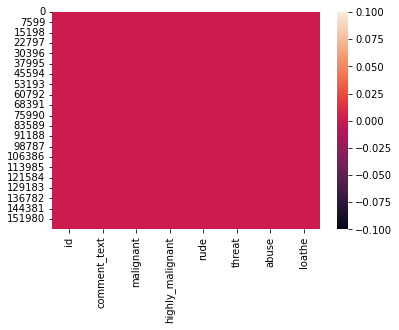

In [9]:
sns.heatmap(df_train.isnull())

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [11]:
#Creating function to see information of dataset
def features_info(dataset):
    
    print("\nRows in dataset =",dataset.shape[0])
    print("\nColumns in dataset =",dataset.shape[1])
    print("\nFeatures names =\n",dataset.columns)
    print("\nDataset types : \n",dataset.dtypes)
    print("\nNull values in dataset :\n",dataset.isnull().sum())
    print("\nAny duplicate values :",dataset.duplicated().values.any(),"\n")
    for i in dataset.columns:
        print("Total unique values in {}={}".format(i,dataset[i].nunique()))

In [12]:
#Lets call the functions
features_info(df_train)


Rows in dataset = 159571

Columns in dataset = 8

Features names =
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

Dataset types : 
 id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

Null values in dataset :
 id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

Any duplicate values : False 

Total unique values in id=159571
Total unique values in comment_text=159571
Total unique values in malignant=2
Total unique values in highly_malignant=2
Total unique values in rude=2
Total unique values in threat=2
Total unique values in abuse=2
Total unique values in loathe=2


In [13]:
df_test.shape

(153164, 2)

In [14]:
df_test.isnull().sum()

id              0
comment_text    0
dtype: int64

<AxesSubplot:>

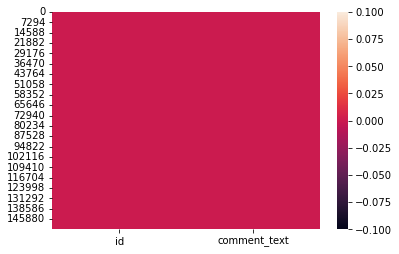

In [15]:
sns.heatmap(df_test.isnull())

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [17]:
#checking ratio of data which contains malignant comments and normal or unoffensive comments.
output_labels = df_train.columns[2:]

# counting non-zero rows i.e. Malignant Comment"s

malignant_comments = len(df_train[df_train[output_labels].any(axis=1)])

# counting rows containing zero i.e. Normal Comments
normal_comments = len(df_train)-malignant_comments

print(f"Total Malignant Comments: {malignant_comments}({round(malignant_comments*100/len(df_train),2)}%)")
print(f"Total Normal Comments: {normal_comments}({round(normal_comments*100/len(df_train),2)}%)")

Total Malignant Comments: 16225(10.17%)
Total Normal Comments: 143346(89.83%)


In [18]:
#checking the length of comments and storing it into another column 'original_length'
#copying df_train into another object df
df = df_train.copy()
df['original_length'] = df.comment_text.str.len()

#checking the first five and last five rows here
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [19]:
df_train.iloc[:,2:].sum()

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

In [20]:
df_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
df_test.describe()

,id,comment_text
count,153164,153164
unique,153164,153164
top,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
freq,1,1


## Data Cleansing

In [22]:
# as the feature 'id' has no relevance w.r.t. model training I am dropping this column
df.drop(columns=['id'],inplace=True)

In [23]:
# converting comment text to lowercase format
df['comment_text']=df.comment_text.str.lower()
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
0,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,264
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0,112
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0,233
3,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0,622
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,67


# Text Processing

### Removing and replacing unwanted characters in the comment_text column

In [24]:
# Replacing '\n' with ' '
df.comment_text = df.comment_text.str.replace('\n',' ')

#Keeping only text with letters a to z, 0 to 9 and words like can't don't could't etc
df.comment_text = df.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

#Removing Stop Words and Punctuations

#Getting the list of stop words of english language as set
stop_words = set(stopwords.words('english'))

#Updating the stop_words set by adding letters from a to z
for ch in range(ord('a'),ord('z')+1):
    stop_words.update(chr(ch))
    
# Updating stop_words further by adding some custom words
custom_words = ("d'aww","mr","hmm","umm","also","maybe","that's","he's","she's","i'll","he'll","she'll","us",
                "ok","there's","hey","heh","hi","oh","bbq","i'm","i've","nt","can't","could","ur","re","ve",
                "rofl","lol","stfu","lmk","ily","yolo","smh","lmfao","nvm","ikr","ofc","omg","ilu")
stop_words.update(custom_words)

# Checking the new list of stop words
print("New list of custom stop words are as follows:\n\n")
print(stop_words)
    


New list of custom stop words are as follows:


{'what', 'nor', 'umm', 'hey', 'you', "d'aww", 'himself', 'are', 't', 'am', "shouldn't", 'will', "couldn't", 'shouldn', 'as', 'during', "that's", 'more', 'because', "don't", 'he', 'c', 'nvm', 'then', 'shan', 'i', "you're", 'can', 'by', 'lmfao', 'than', 'your', 'v', "she's", 'between', 'don', 'll', 'h', 'below', "needn't", 'their', 'this', 'lmk', 'hasn', "you'd", 'we', 'against', "aren't", 'b', 'ok', 'all', 'our', 'about', 'of', 'weren', 'had', 'ily', 'into', 'so', 'mightn', 'was', "haven't", 'u', 'l', 'aren', 'ourselves', 'or', 'j', 'k', 'could', 'also', 'herself', "he's", 'doesn', 'm', 'there', 'on', 'g', 'wouldn', 'not', "there's", "she'll", 'to', 'smh', 'for', 'further', 'yourselves', 'ours', 'down', 'most', 'have', 'each', 'd', 'hi', 'is', 'rofl', 'isn', 'y', "weren't", "didn't", 'won', 'my', 'did', 'ain', 'didn', 'hadn', 'who', 'him', 'her', 'why', 'few', 'ma', 'stfu', 'while', 'those', 'hmm', 'ikr', 'off', "hasn't", 'do', 'ilu', 'the

### Removing stop words and Punctuations

In [25]:
df.comment_text = df.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

#Removing Punctuations
df.comment_text = df.comment_text.str.replace("[^\w\d\s]","")

#checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
120278,please vandalize pages edit drum continue bloc...,0,0,0,0,0,0,145
104134,work npia vandalised anything fact written npi...,0,0,0,0,0,0,381
127010,note made comment sure protocol notifications ...,0,0,0,0,0,0,99
108180,fact stupid limited understanding plays acedem...,1,0,0,0,0,0,206
146310,thank know plat duuts frisian plattdeutsch go ...,0,0,0,0,0,0,114
22562,tya allen talk ctrb mail,0,0,0,0,0,0,82
117174,cnn article merits consideration imo,0,0,0,0,0,0,43
64914,list countries military expenditures need help...,0,0,0,0,0,0,1183
90158,russian gave several sources say millions peop...,0,0,0,0,0,0,261
156803,important make finland scandinavia difference ...,0,0,0,0,0,0,455


## Stemming:

In [26]:
#Stemming words:
snb_stem = SnowballStemmer('english')
df.comment_text = df.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

#Checking any 10 random rows to see the applied changes
df.sample(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length
37898,quot materi paraphras,0,0,0,0,0,0,44
12140,android sideload alway process get line busi a...,0,0,0,0,0,0,205
145280,insert suggest tribe dan simpli said historian...,0,0,0,0,0,0,282
42434,film nehram hope studi go well vacat first eve...,0,0,0,0,0,0,1455
19706,question ed wonder feel share common ancestor ...,1,0,0,0,0,0,274
34020,best wish bet wish warmest greet land smile le...,0,0,0,0,0,0,162
79779,pleas stop continu vandal page block edit wiki...,0,0,0,0,0,0,98
68057,state user troll assum good faith threaten use...,0,0,0,0,0,0,219
158988,yes understand yes yes yes,0,0,0,0,0,0,33
44466,wonder chang color raw signatur,0,0,0,0,0,0,58


In [27]:
#Checking the length of comment_text after cleaning and storing it in cleaned_length variable
df["cleaned_length "] = df.comment_text.str.len()

#Taking a loot at first 10 rows of data
df.head(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,original_length,cleaned_length
0,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0,264,135
1,match background colour seem stuck thank talk ...,0,0,0,0,0,0,112,57
2,man realli tri edit war guy constant remov rel...,0,0,0,0,0,0,233,112
3,make real suggest improv wonder section statis...,0,0,0,0,0,0,622,310
4,sir hero chanc rememb page,0,0,0,0,0,0,67,26
5,congratul well use tool well talk,0,0,0,0,0,0,65,33
6,cocksuck piss around work,1,1,1,0,1,0,44,25
7,vandal matt shirvington articl revert pleas ban,0,0,0,0,0,0,115,47
8,sorri word nonsens offens anyway intend write ...,0,0,0,0,0,0,472,235
9,align subject contrari dulithgow,0,0,0,0,0,0,70,32


In [28]:
#Now checking the percentage of length cleaned
print(f"Total Original Length          : {df.original_length.sum()}")
print(f"Percentage of Length Cleaned   : {(df.original_length.sum())*100/df.original_length.sum()}%")

Total Original Length          : 62893130
Percentage of Length Cleaned   : 100.0%


# Visualization

malignant


0    144277
1     15294
Name: malignant, dtype: int64


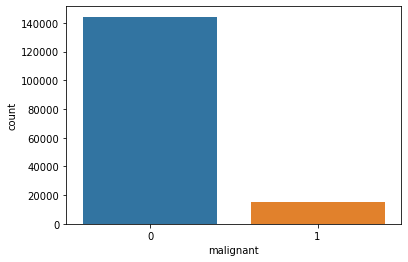

highly_malignant


0    157976
1      1595
Name: highly_malignant, dtype: int64


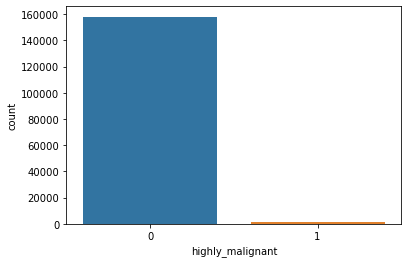

loathe


0    158166
1      1405
Name: loathe, dtype: int64


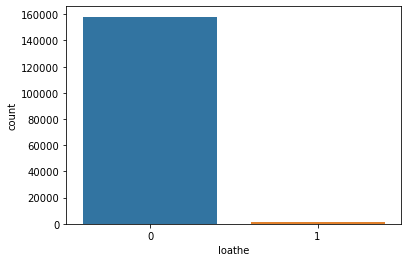

rude


0    151122
1      8449
Name: rude, dtype: int64


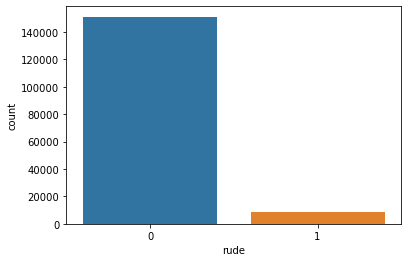

abuse


0    151694
1      7877
Name: abuse, dtype: int64


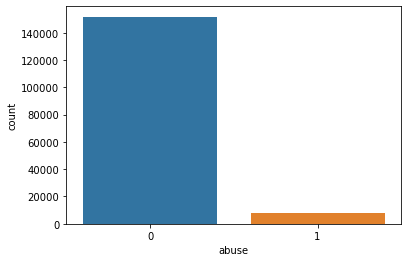

threat


0    159093
1       478
Name: threat, dtype: int64


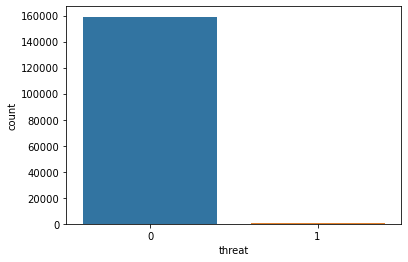

In [29]:
col_name=['malignant','highly_malignant','loathe','rude','abuse','threat']
for i in col_name:
    print(i)
    print("\n")
    print(df[i].value_counts())
    sns.countplot(df[i])
    plt.show()


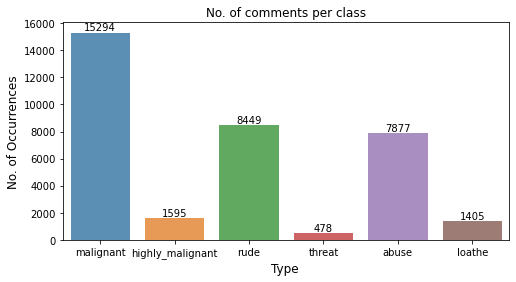

In [30]:
plt.figure(figsize=(8,4))
ax = sns.barplot(df_train.iloc[:,2:].sum().index, df_train.iloc[:,2:].sum().values, alpha=0.8)
plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = df_train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()


In [31]:
# Create a bar graph 
sum_mal = df_train['malignant'].sum() / len(df_train) * 100
sum_hig = df_train['highly_malignant'].sum() / len(df_train) * 100
sum_rude = df_train['rude'].sum() / len(df_train) * 100
sum_thr = df_train['threat'].sum() / len(df_train) * 100
sum_abu = df_train['abuse'].sum() / len(df_train) * 100
sum_loa = df_train['loathe'].sum() / len(df_train) * 100


In [32]:
# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)


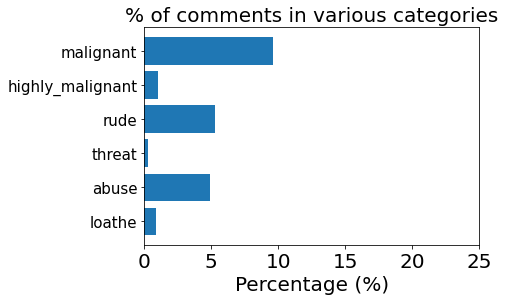

In [33]:
# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_mal, sum_hig, sum_rude, sum_thr, sum_abu, sum_loa])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=20)
plt.yticks(ind, ('malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe' ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()


## Comparing normal comments and bad comments using count plot


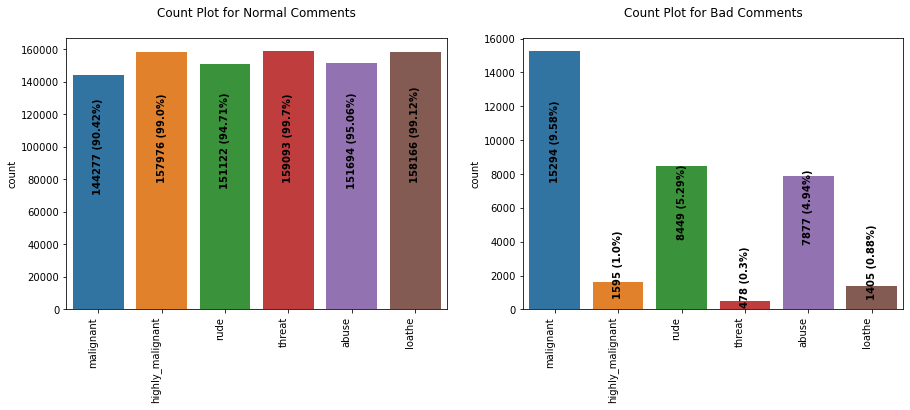

In [34]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

for i in range(2):
    sns.countplot(data=df[output_labels][df[output_labels]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n")
    else:
        ax[i].set_title("Count Plot for Bad Comments\n")
        
    ax[i].set_xticklabels(output_labels, rotation=90, ha="right")
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1

plt.show()


## Observation:

1. Dataset consists of higher number of Normal Comments than Bad or Malignant Comments. Therefore, it is clear that dataset is imbalanced and needs to be handle accordingly.

2. Most of the bad comments are of type malignant while least number of type threat is present in dataset.

3. Majority of bad comments are of type malignant, rude and abuse.


## Comparing the comment text length distribution before cleaning and after cleaning


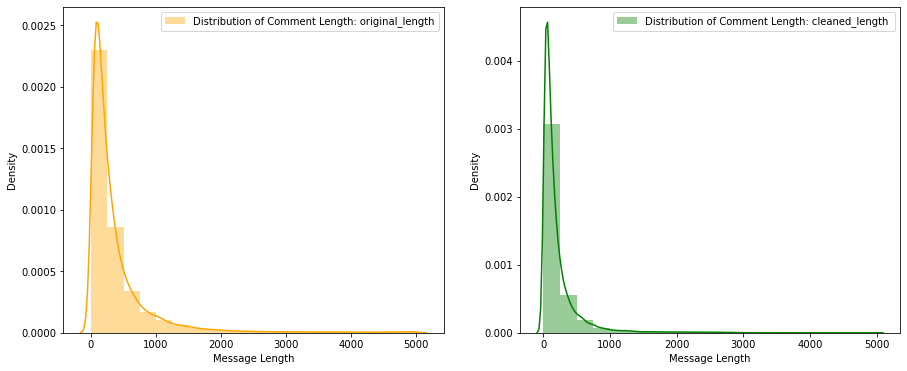

In [35]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
j=0
colors = ['orange','green']
for i in df.columns[-2:]:
    label_text = f"Distribution of Comment Length: {i}"
    sns.distplot(df[i],ax=ax[j],bins=20,color=colors[j],label=label_text)
    ax[j].set_xlabel("Message Length")
    ax[j].legend()
    j += 1
    
plt.show()

Observation:
    

Before cleaning comment_text column most of the comment's length lies between 0 to 1100 while after cleaning it has been reduced between 0 to 900.


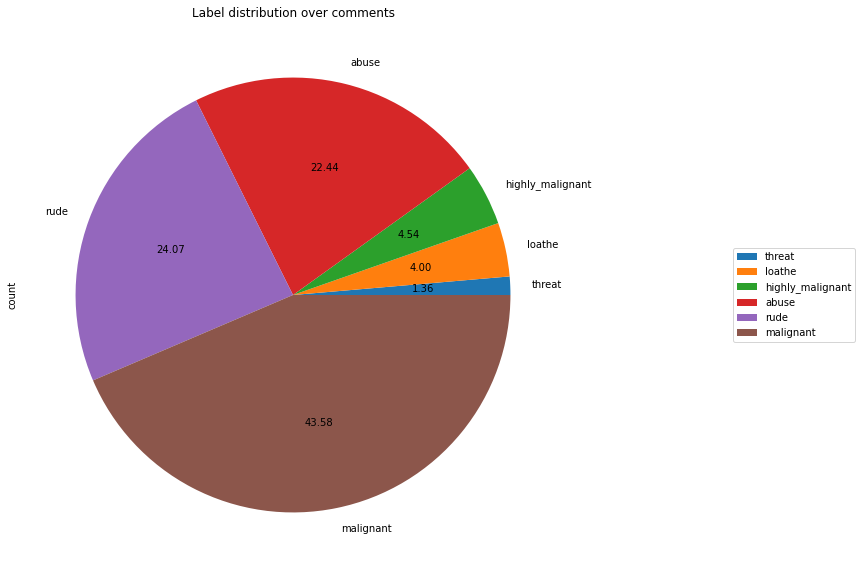

In [36]:
# Visualizing the label distribution of comments using pie chart

comments_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
df_distribution = df_train[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (15, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))


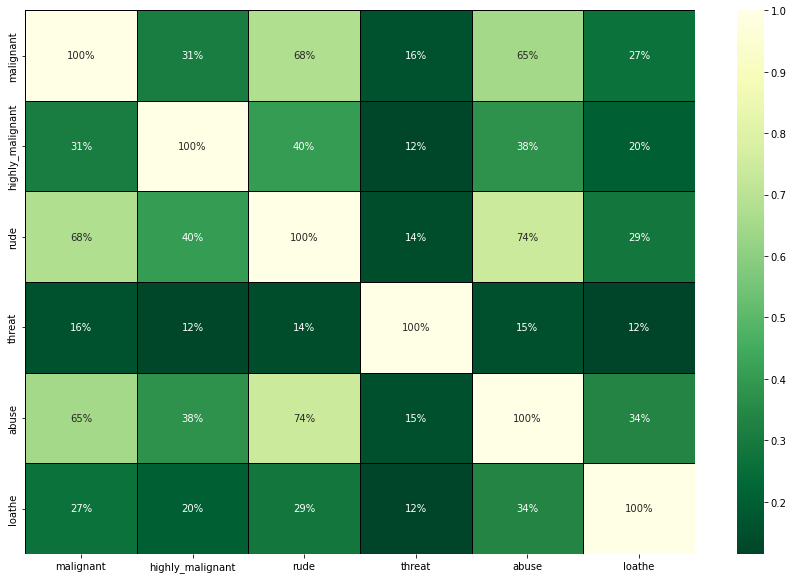

In [37]:
# Plotting heatmap for visualizing the correlation

plt.figure(figsize=(15, 10))
corr = df_train.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', cmap='YlGn_r', annot=True)
plt.show()


## WordCloud: Getting sense of loud words in each of the output labels.


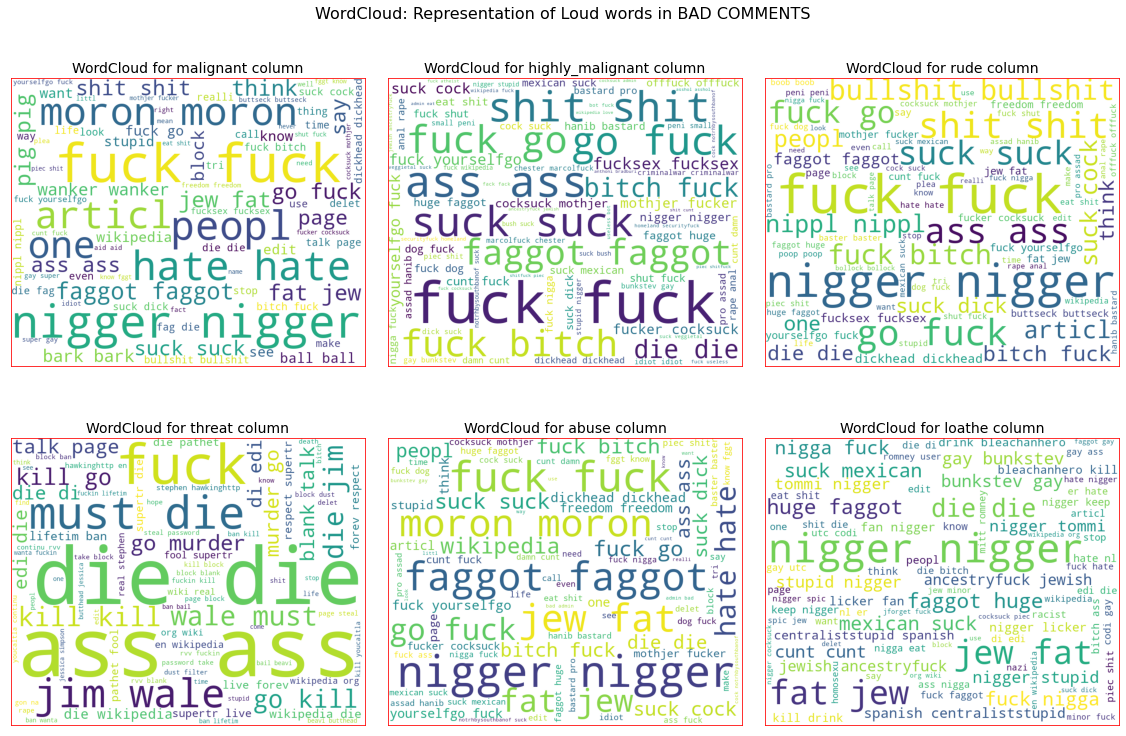

In [38]:
cols = 3
rows = len(output_labels)//cols
if len(output_labels) % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(16,rows*cols*1.8))
fig.subplots_adjust(top=0.8, hspace=0.3)

p=1
for i in output_labels:
    word_cloud = WordCloud(height=650, width=800,
                           background_color="white",max_words=80).generate(' '.join(df.comment_text[df[i]==1]))
    ax = fig.add_subplot(rows,cols,p)
    ax.imshow(word_cloud)
    ax.set_title(f"WordCloud for {i} column",fontsize=14)
    for spine in ax.spines.values():
        spine.set_edgecolor('r')
       
    ax.set_xticks([])
    ax.set_yticks([])
    p += 1

fig.suptitle("WordCloud: Representation of Loud words in BAD COMMENTS",fontsize=16)
fig.tight_layout(pad=2)
plt.show()


Observation:

1. From wordcloud of malignant comments, it is clear that it mostly consists of words like fuck, nigger, moron, hate, suck ect.
2. From wordcloud of highly_malignant comments, it is clear that it mostly consists of words like ass, fuck, bitch, shit, die, suck, faggot ect.
3. From wordcloud of rude comments, it is clear that it mostly consists of words like nigger, ass, fuck, suck, bullshit, bitch etc.
4. From wordcloud of threat comments, it is clear that it mostly consists of words like die, must die, kill, murder etc.
5. From wordcloud of abuse comments, it is clear that it mostly consists of words like moron, nigger, fat, jew, bitch etc.
6. From wordcloud of loathe comments, it is clear that it mostly consists of words like nigga, stupid, nigger, die, gay cunt etc.


# Data Preparation for Model Training and Testing


### 1. Convert text to Vectors


In [39]:
# Converting text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(max_features=4000)
features = tfidf.fit_transform(df.comment_text).toarray()

# Checking the shape of features
features.shape


(159571, 4000)

### 2. Seperating Input and Output Variables


In [40]:
# input variables
X = features

# output variables
Y = csr_matrix(df[output_labels]).toarray()

# checking shapes of input and output variables to take care of data imbalance issue
print("Input Variable Shape:", X.shape)
print("Output Variable Shape:", Y.shape)


Input Variable Shape: (159571, 4000)
Output Variable Shape: (159571, 6)


#### As our target or depedent data is labeled either 0 or 1 which indicates that we are dealing with Classification type of problem. Let's builid a model on Classification now.


# Classification Machine Learning Model building


### 3. Training and Testing Model on our train dataset


In [41]:
# Creating a function to train and test model
def build_models(models,x,y,test_size=0.33,random_state=42):
    # spliting train test data using train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=random_state)
    
    # training models using BinaryRelevance of problem transform
    for i in tqdm.tqdm(models,desc="Building Models"):
        start_time = timeit.default_timer()
        
        sys.stdout.write("\n=======================================================================================\n")
        sys.stdout.write(f"Current Model in Progress: {i}")
        sys.stdout.write("\n=======================================================================================\n")
        
        br_clf = BinaryRelevance(classifier=models[i]["name"],require_dense=[True,True])
        print("Training: ",br_clf)
        br_clf.fit(x_train,y_train)
        
        print("Testing: ")
        predict_y = br_clf.predict(x_test)
        
        ham_loss = hamming_loss(y_test,predict_y)
        sys.stdout.write(f"\n\tHamming Loss  : {ham_loss}")
                
        ac_score = accuracy_score(y_test,predict_y)
        sys.stdout.write(f"\n\tAccuracy Score: {ac_score}")
        
        cl_report = classification_report(y_test,predict_y)
        sys.stdout.write(f"\n{cl_report}")
        
        end_time = timeit.default_timer()
        sys.stdout.write(f"Completed in [{end_time-start_time} sec.]")
        
        models[i]["trained"] = br_clf
        models[i]["hamming_loss"] = ham_loss
        models[i]["accuracy_score"] = ac_score
        models[i]["classification_report"] = cl_report
        models[i]["predict_y"] = predict_y
        models[i]["time_taken"] = end_time - start_time
                      
        sys.stdout.write("\n=======================================================================================\n")
    
    models["x_train"] = x_train
    models["y_train"] = y_train
    models["x_test"] = x_test
    models["y_test"] = y_test
    
    return models

In [42]:
!pip install --upgrade pip


In [43]:
!pip install scikit-multilearn


In [45]:
# Preparing the list of models for classification purpose
from skmultilearn.problem_transform import BinaryRelevance
models = {"GaussianNB": {"name": GaussianNB()},
          "MultinomialNB": {"name": MultinomialNB()},
          "Logistic Regression": {"name": LogisticRegression()},
          "Random Forest Classifier": {"name": RandomForestClassifier()},
          "Support Vector Classifier": {"name": LinearSVC(max_iter = 3000)},
          "Ada Boost Classifier": {"name": AdaBoostClassifier()},
          "Decision Tree Classifier": {"name": DecisionTreeClassifier()},
          "Bagging Classifier": {"name": BaggingClassifier(base_estimator=LinearSVC())},
         }

# Taking one forth of the total data for training and testing purpose
half = len(df)//4
trained_models = build_models(models,X[:half,:],Y[:half,:])


Building Models:   0%|          | 0/8 [00:00<?, ?it/s]


Current Model in Progress: GaussianNB
Training:  BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.21560957083175086
	Accuracy Score: 0.4729965818458033
              precision    recall  f1-score   support

           0       0.16      0.79      0.26      1281
           1       0.08      0.46      0.13       150
           2       0.11      0.71      0.19       724
           3       0.02      0.25      0.03        44
           4       0.10      0.65      0.17       650
           5       0.04      0.46      0.07       109

   micro avg       0.11      0.70      0.20      2958
   macro avg       0.08      0.55      0.14      2958
weighted avg       0.12      0.70      0.21      2958
 samples avg       0.05      0.07      0.05      2958
Completed in [15.07817609999995 sec.]

Current Model in Progress: MultinomialNB
Training:  BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.02409165

# Hyperparameter Tuning

In [50]:
# Choosing Linear Support Vector Classifier model

fmod_param = {'estimator__penalty' : ['11', '12'],
              'estimator__loss' : ['hinge', 'squared_hinge'],
              'estimator__multi_class' : ['ovr', 'crammer_singer'],
              'estimator__random_state' : [42, 72, 111]
             }
SVC = OneVsRestClassifier(LinearSVC())
GSCV = GridSearchCV(SVC, fmod_param, cv=3)
x_train,x_test,y_train,y_test = train_test_split(X[:half,:], Y[:half,:], test_size=0.30, random_state=42)
GSCV.fit(x_train,y_train)
GSCV.best_params_


{'estimator__loss': 'hinge',
 'estimator__multi_class': 'crammer_singer',
 'estimator__penalty': '11',
 'estimator__random_state': 42}

In [51]:
Final_Model = OneVsRestClassifier(LinearSVC(loss='hinge', multi_class='ovr', penalty='l2', random_state=42))
Classifier = Final_Model.fit(x_train, y_train)
fmod_pred = Final_Model.predict(x_test)
fmod_acc = (accuracy_score(y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)
h_loss = hamming_loss(y_test,fmod_pred)*100
print("Hamming loss for the Best Model is:", h_loss)

Accuracy score for the Best Model is: 91.51069518716578
Hamming loss for the Best Model is: 1.9593917112299464


# AUC ROC Curve for Final Model


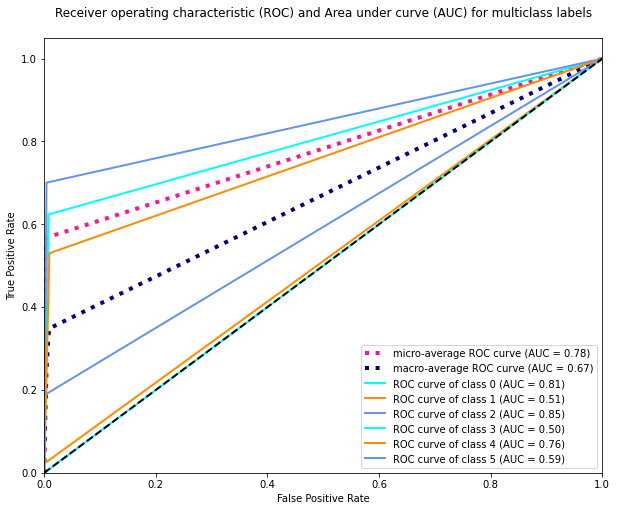

In [52]:
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], fmod_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), fmod_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC) and Area under curve (AUC) for multiclass labels\n")
plt.legend(loc="lower right")
plt.show()


# Confusion Matrix for Final Model

In [ ]:
print("Confusion matrix:\n\n", multilabel_confusion_matrix(y_test, fmod_pred))

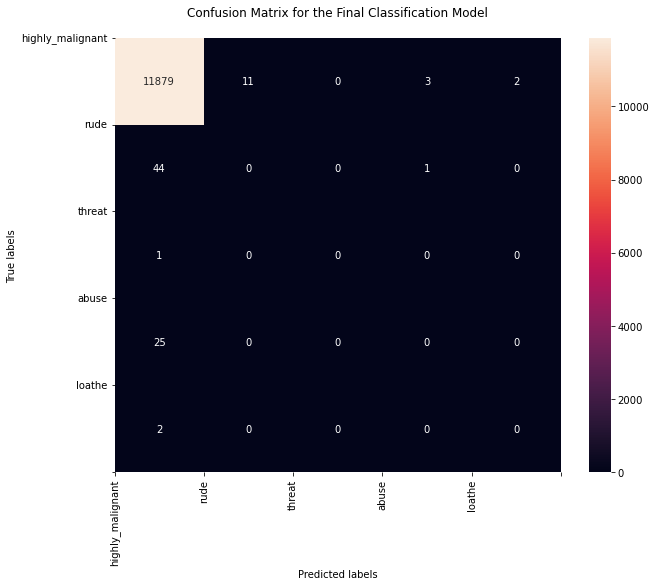

In [53]:
plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size
ax= plt.subplot()
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(fmod_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# title, labels and ticks
ax.set_title('Confusion Matrix for the Final Classification Model\n'); 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
loc = plticker.MultipleLocator()
ax.xaxis.set_major_locator(loc); ax.yaxis.set_major_locator(loc);
ax.set_xticklabels(comments_labels); ax.set_yticklabels(comments_labels);
plt.xticks(rotation=90); plt.yticks(rotation=0);
plt.show()


# Model Saving or Serialization


In [54]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model
joblib.dump(best_model,open('Malignant_comments_classifier_Project.pkl','wb'))


# Preprocessing Pipeline for test dataframe


The following preprocessing pipeline is required to perform model prediction:

1. Use the test dataset
2. Remove null values if any
3. Drop column id
4. Convert comment text to lower case and replace '\n' with single space
5. Keep only text data ie. a-z' and remove other data from comment text
6. Remove stop words and punctuations
7. Apply Stemming using SnowballStemmer
8. Convert text to vectors using TfidfVectorizer
9. Load saved or serialized best model
10. Predict values and create a new CSV file"


In [56]:
# Remove null values
if df_test.isnull().sum()[1] != 0:
    df_test.dropna(inplace=True)
    
# Drop coulmn id
df_test.drop(columns=['id'],inplace=True)

# Convert comment text to lower case and replace '\n' with single space
df_test["comment_text"] = df_test.comment_text.str.lower()
df_test["comment_text"] = df_test.comment_text.str.replace('\n',' ')

# Keep only text data i.e., a-z' and remove other data from comment text.
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(regexp_tokenize(x,"[a-z']+")))

# Remove stopwords
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words).strip())

# Remove punctuations
df_test.comment_text = df_test.comment_text.str.replace("[^\w\d\s]","")

# Apply Stemming using SnowballStemmer
df_test.comment_text = df_test.comment_text.apply(lambda x: ' '.join(snb_stem.stem(word) for word in word_tokenize(x)))

print(df_test.info(memory_usage="deep"))

# Convert text to vectors using TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word', max_features=4000)
test_features = tfidf.fit_transform(df_test.comment_text).toarray()

# Load saved or serialized model and predict
model_loaded = joblib.load('Malignant_comments_classifier_Project.pkl')

# Make predictions and view the results
predict_test = model_loaded.predict(test_features)

# Saving predicted values into a CSV file
pd.DataFrame(predict_test.toarray()).to_csv('Predicted_test_output.csv')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 37.2 MB
None


In [57]:
df1 = pd.read_csv('Predicted_test_output.csv')
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1.rename({'0':'malignant', '1':'highly_malignant', '2':'rude', '3':'threat', '4':'abuse', '5':'loathe'}, 
           axis='columns', inplace=True)
df2=df_test.copy()
df = pd.concat([df2, df1], axis=1)
df


,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,yo bitch ja rule succes ever what hate sad mof...,0,0,0,0,0,0
1,rfc titl fine imo,0,0,0,0,0,0
2,sourc zaw ashton lapland,0,0,0,0,0,0
3,look back sourc inform updat correct form gues...,0,0,0,0,0,0
4,anonym edit articl,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,total agre stuff noth long crap,0,0,0,0,0,0
153160,throw field home plate get faster throw cut ma...,0,0,0,0,0,0
153161,okinotorishima categori see chang agre correct...,0,0,0,0,0,0
153162,one found nation eu germani law return quit si...,0,0,0,0,0,0


In [58]:
df.to_csv('test_dataset_predictions.csv', index=False)


## Inference

Starting with univariate analysis, with the help of count plot it was found that dataset is imbalanced with having higher number of records for normal comments than bad comments (including malignant, highly malignant, rude, threat, abuse and loathe). Also, with the help of distribution plot for comments length it was found that after cleaning most of comments length decreases from range 0-1100 to 0-900. Moving further with wordcloud it was found that malignant comments consists of words like fuck, nigger, moron, hate, suck etc. highly_malignant comments consists of words like ass, fuck, bitch, shit, die, suck, faggot etc. rude comments consists of words like nigger, ass, fuck, suck, bullshit, bitch etc. threat comments consists of words like die, must die, kill, murder etc. abuse comments consists of words like moron, nigger, fat, jew, bitch etc. and loathe comments consists of words like nigga, stupid, nigger, die, gay, cunt etc.


## Problems faced while working in this project:


1. More computational power was required as it took more than 2 hours

2. Imbalanced dataset and bad comment texts

3. Good parameters could not be obtained using hyperparameter tuning as time was consumed more


## Areas of improvement:

1. Could be provided with a good dataset which doesnot take more time.
2. Less time complexity
3. Providing a proper balanced dataset with less errors.


###### My point of view from my project is that we need to use proper words which are respectful and also avoid using abusive, vulgar and worst words in social media. It can cause many problems which could affect our lives. Try to be polite, calm and composed while handling stress and negativity and one of the best solution is to avoid it and overcoming in a positive manner.
